# code2vec using Embeddings and NN

We are going to represent programs as token vectors and learn their representations using embeddings

We are going to create a prediction problem and try to predict whether the program submitted with be considered as correct, i.e. the program pass the testcases specified by the lecturer. Creating a prediction problem to learn representations of the data is a useful approach. There is no easy way to represent these programs so we are going to learn these representations. 
 

* https://code.google.com/archive/p/word2vec/

* https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa

* https://www.cse.iitb.ac.in/~pb/papers/bionlp-acl17-medical-coding.pdf

* https://github.com/sloomba/protein2vec

* https://github.com/samiroid/usr2vec

* https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

* http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

* Topic Modelling for Humans: https://radimrehurek.com/gensim/

* https://spacy.io/models/

* https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/

* Code2Vec https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8031179&tag=1, https://arxiv.org/pdf/1803.09473.pdf, https://code2vec.org/

* From People2Vec to Emotional AI: http://people2vec.org/

* Using Word2vec for Music Recommendations: https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484

* Source code identifier embeddings: https://blog.sourced.tech/post/id2vec/

* Recommending Recommendation Systems: https://gab41.lab41.org/recommending-recommendation-systems-cc39ace3f5c1, https://github.com/Lab41/Misc/blob/master/blog/python2vec/Python2Vec%20Example.ipynb

* Python2Vec: Word Embeddings for Source Code: https://gab41.lab41.org/python2vec-word-embeddings-for-source-code-3d14d030fe8f

* Anything2Vec: https://gab41.lab41.org/anything2vec-e99ec0dc186

* AutoKeras: https://towardsdatascience.com/autokeras-the-killer-of-googles-automl-9e84c552a319, https://autokeras.com/

* Learning Program Embeddings to Propagate Feedback on Student Code: https://web.stanford.edu/~cpiech/bio/papers/programEncoding.pdf, https://github.com/chrispiech/refactoredEncoder

* Research at Code.org: https://code.org/research

* Cheatsheet: https://startupsventurecapital.com/essential-cheat-sheets-for-machine-learning-and-deep-learning-researchers-efb6a8ebd2e5

* DCU Deep Learning Summer School: https://telecombcn-dl.github.io/2018-dlcv/, https://www.slideshare.net/xavigiro/d1l2-the-neural-network-zoo-upc-2018-deep-learning-for-computer-vision

* Embeddings: https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## VECTORIZE

**Programming data**: Student develop programs locally for the laboratory sheets of computer programming courses at our university. These programs are submitted by them to an automatic grading platform that runs some test cases specified by the lecturer on each program. A JSON output for those testcases and whether the program passed them or not along with the actual code is stored.

In [3]:
!ls data/raw/programming_data.json

data/raw/programming_data.json


In [4]:
dataframe = pd.read_json('data/raw/programming_data.json')

In [5]:
dataframe.head(2)

,academic_year_0,academic_year_1,correct,date,extension,ip,module,task,upload,user
0,2016,2017,True,2016-09-19 14:11:41,py,,ca277,add.py,#!/usr/bin/env python\n\na = int(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c
1,2016,2017,True,2016-09-19 14:17:33,py,,ca277,concat-lines.py,#!/usr/bin/env python\n\na = str(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c


In [6]:
'{:,}'.format(len(dataframe))

'591,707'

Grab only code submissions from Python modules:

In [7]:
PYTHON_MODULES = [
    'ca116', 
    'ca117', 
    'ca177', 
    'ca277', 
    'ca278',
]

In [8]:
dataframe = dataframe[dataframe['module'].isin(PYTHON_MODULES)]

In [9]:
'{:,}'.format(len(dataframe))

'490,820'

Target value:

In [10]:
dataframe.correct.value_counts()

False    296369
True     194451
Name: correct, dtype: int64

Remove comments:

In [11]:
import re
def remove_comments(text):
    return re.sub(re.compile('#.*?\n'), '', text)

Grab docs (code submissions) and labels (correct or not):

In [12]:
def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        code = remove_comments(
            df.at[index, 'upload']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'correct'])
        _labels.append(label)
    return _docs, _labels

In [13]:
docs, labels = get_docs_and_labels(dataframe)

In [14]:
'{:,}'.format(len(docs))

'490,820'

In [15]:
docs[0]

u'\na = int(raw_input())\nb = int(raw_input())\n\nprint a + b\n\n\n'

In [16]:
labels[0]

1

## 1) Programs as word vectors

https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/

In [17]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [18]:
NUM_WORDS = 2000 # Originally 231,659 words

In [19]:
def get_tokenizer():

    return Tokenizer(num_words=NUM_WORDS, 
                     filters='\t\n', 
                     lower=True, 
                     split=' ', 
                     char_level=False)

In [20]:
word_t = get_tokenizer()

In [21]:
word_t.fit_on_texts(docs)

In [22]:
# word_counts: a dictionary of words and their counts.
word_t.word_counts['if'] # word count

552539

In [23]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(word_t.document_count)

'Number docs: 490,820'

In [24]:
# word_index: a dictionary of words and their uniquely assigned integers.
word_t.word_index['if'] # index

4

In [25]:
# word_docs: a dictionary of words and how many documents each appeared in.
word_t.word_docs['if']

298487

In [26]:
import pickle

with open('word_tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
sequences = word_t.texts_to_sequences(docs)

In [28]:
sequences[0]

[17, 1, 358, 50, 1, 358, 6, 17, 3, 50]

Look at the lenght of these sequences:

In [29]:
len_seqs = [len(s) for s in sequences]

In [30]:
np.mean(len_seqs), np.std(len_seqs), np.max(len_seqs)

(38.591420480013042, 38.577314137088699, 2358)

In [31]:
MAX_LENGTH = 50

Dictionary to transform a vector back to the program:

In [32]:
id_to_word = { v: k for k, v in word_t.word_index.items() }

In [33]:
id_to_word[1]

u'='

In [34]:
[id_to_word[index] for index in sequences[0]]

[u'a',
 u'=',
 u'int(raw_input())',
 u'b',
 u'=',
 u'int(raw_input())',
 u'print',
 u'a',
 u'+',
 u'b']

Pad documents:

In [35]:
from keras.preprocessing.sequence import pad_sequences

In [36]:
# pad documents
padded_docs = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [37]:
padded_docs[0]

array([ 17,   1, 358,  50,   1, 358,   6,  17,   3,  50,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Model:

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [39]:
def get_model():

    # define the model
    model = Sequential()
    model.add(Embedding(NUM_WORDS, 100, input_length=MAX_LENGTH))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    return model

In [40]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# fit the model
# model.fit(padded_docs, labels, epochs=2, verbose=1)

model.fit(padded_docs, 
          labels,
          batch_size=128,
          epochs=2,
          validation_split=0.2)

Train on 392656 samples, validate on 98164 samples
Epoch 1/2
392656/392656 [==============================] - 20s 50us/step - loss: 0.5924 - acc: 0.6778 - val_loss: 0.6619 - val_acc: 0.6367
Epoch 2/2
392656/392656 [==============================] - 24s 62us/step - loss: 0.5324 - acc: 0.7256 - val_loss: 0.6963 - val_acc: 0.6431


In [42]:
# evaluate the model
word_loss, word_accuracy = model.evaluate(padded_docs, labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (word_accuracy * 100, word_loss * 100))

490820/490820 [==============================] - 21s 43us/step
Accuracy: 72.676338, Loss: 53.910754


In [43]:
def get_embeddings(model):

    # Embedding Layer
    embedding_layer = model.layers[0]
    embeddings = embedding_layer.get_weights()[0]
    print 'Embedding Layer shape:', embeddings.shape
    
    return embeddings

In [44]:
embeddings = get_embeddings(model)

Embedding Layer shape: (2000, 100)


In [45]:
embeddings[0]

array([ -1.40533624e-02,  -6.30010152e-04,  -4.87751653e-03,
         1.23435557e-02,   7.69970240e-03,   1.30154993e-02,
        -3.86407902e-03,  -1.15885120e-03,   1.67386455e-03,
        -1.14646376e-04,   1.25387367e-02,  -7.93344993e-03,
         5.53955417e-03,  -2.40030186e-03,  -9.73123033e-03,
        -5.90304146e-03,  -3.61451437e-03,  -3.15545569e-03,
         8.73463880e-03,  -7.06237555e-03,   2.45544245e-03,
         1.20565258e-02,   2.65514646e-02,   1.15392555e-04,
        -6.49260264e-03,  -7.06423307e-04,  -3.10808513e-02,
         7.78772822e-03,   6.27618516e-03,   2.53215637e-02,
         1.97101682e-02,   2.10167095e-03,  -2.49264743e-02,
        -1.94434840e-02,   6.58143545e-03,  -1.76395718e-02,
         1.10929674e-02,  -7.89475814e-03,   1.63195431e-02,
         9.89377405e-03,   8.06056196e-04,   6.63035968e-03,
         2.10581832e-02,  -7.22340913e-03,  -1.42571675e-02,
        -4.72415471e-03,  -5.21894079e-03,  -8.14696401e-03,
         1.15964562e-02,

In [46]:
# np.save('data/processed/word_embeddings', embeddings)

In [47]:
from sklearn.decomposition import PCA

def get_pca(embeddings):

    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(embeddings)
    print 'PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_)
    return principal_components

In [48]:
pca = get_pca(embeddings)

PCA explained variance ratio: [ 0.17458071  0.06768906] Total: 0.242269769311


In [49]:
def get_top_words(tokenizer, N=50):
    
    return [word for word, occurrences in sorted(tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:N]]

In [50]:
top_words = get_top_words(word_t)

In [51]:
def plot_embeddings(low_dim_embs, id_to_word, top_words, figsize=(8, 8)):

    plt.figure(figsize=figsize, dpi=100)
    ax = plt.axes()
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    i = 0
    while i < len(low_dim_embs):

        if i in id_to_word:
            
            x, y = low_dim_embs[i, :]
            word = id_to_word[i]

            if word in top_words:
                plt.scatter(x, y, color='b')
                plt.annotate(word,
                            xy=(x, y),
                            xytext=(5, 2),
                            textcoords='offset points',
                            ha='right',
                            va='bottom',
                            fontsize=14)
        
        i += 1

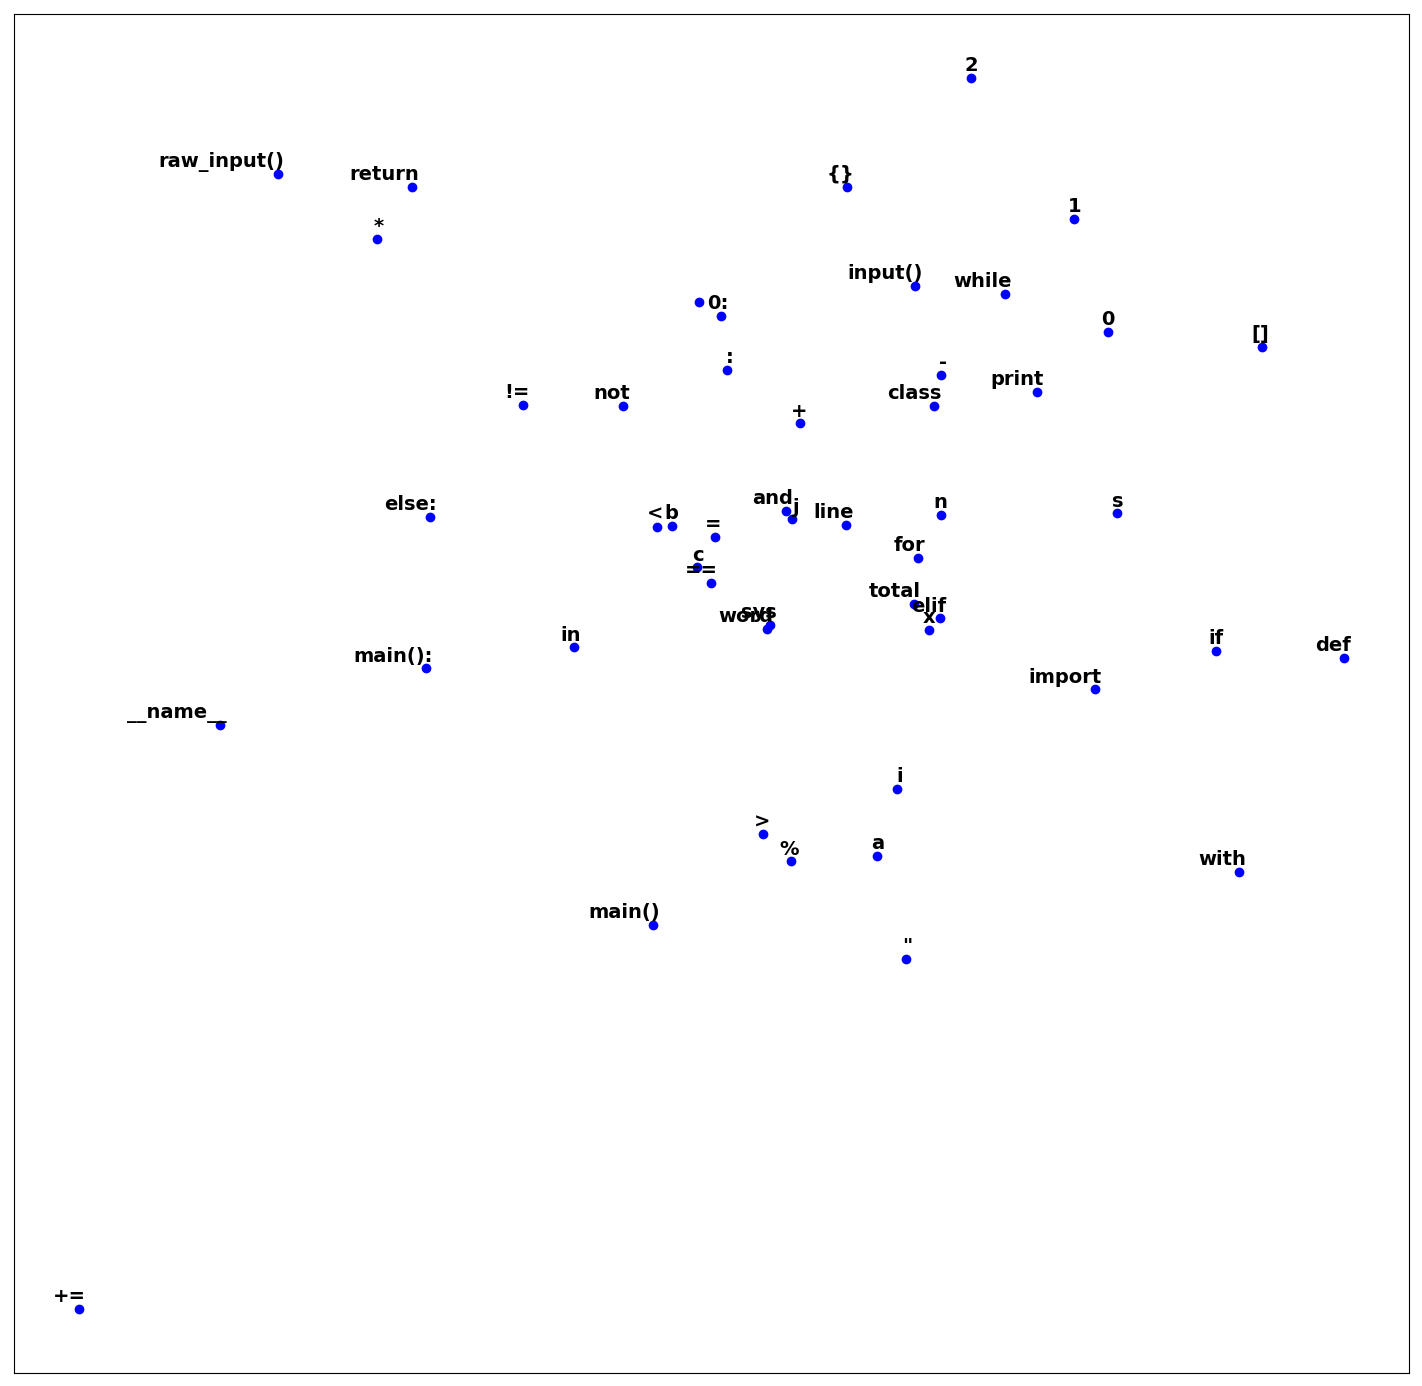

In [52]:
plot_embeddings(pca, id_to_word, top_words, figsize=(18, 18))

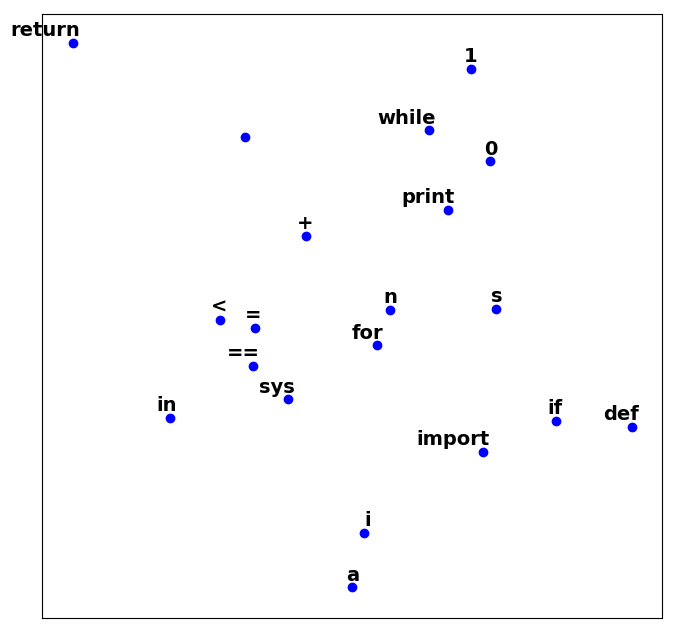

In [54]:
plot_embeddings(pca, id_to_word, get_top_words(word_t, 20))

Measure the distance between vectors:

In [136]:
from scipy.spatial.distance import euclidean, cosine

def get_vector_distance(embeddings, tok, word1, word2):
    
    return euclidean(embeddings[tok.word_index[word1]], 
                     embeddings[tok.word_index[word2]])
    
def get_vector_cosine_distance(embeddings, tok, word1, word2):
    
    return cosine(embeddings[tok.word_index[word1]], 
                  embeddings[tok.word_index[word2]])

Cosine similarity:

In [84]:
get_vector_cosine_distance(embeddings, word_t, '<', '>')

1.1739165000252259

In [95]:
get_vector_cosine_distance(embeddings, word_t, 'elif', 'else:')

0.99488632036367319

In [194]:
get_vector_cosine_distance(embeddings, word_t, '+', '-')

0.77174754100841758

Euclidean distance:

In [133]:
get_vector_distance(embeddings, word_t, '<', '>')

0.8794395327568054

In [85]:
get_vector_distance(embeddings, word_t, '==', '!=')

0.71771240234375

In [93]:
get_vector_distance(embeddings, word_t, 'if', 'elif')

0.8418874740600586

In [94]:
get_vector_distance(embeddings, word_t, 'elif', 'else:')

0.929915726184845

In [96]:
get_vector_distance(embeddings, word_t, '+', '-')

0.7610770463943481

In [101]:
get_vector_distance(embeddings, word_t, 'for', 'while')

0.6867375373840332

In [102]:
get_vector_distance(embeddings, word_t, 'def', 'import')

0.6500228643417358

In [158]:
def get_neighbors(word, emb, tok, id_to_item, top_n=5):

    dist = {}
    i = 0
    while i < len(emb):

        if i in id_to_item:
            w = id_to_item[i]
            if w != word:
                dist[w] = get_vector_cosine_distance(emb, tok, word, w)
        
        i += 1

    for key, value in sorted(dist.iteritems(), key=lambda (k,v): (v,k), reverse=True)[:top_n]:
        print "%s: %s" % (key, value)

In [159]:
get_neighbors('if', embeddings, word_t, id_to_word)

l[0]: 1.64544129624
swap_unique_keys_values(d):: 1.61630962457
'9',: 1.61292221568
world.\n"): 1.61007351052
none:: 1.56990433325


In [97]:
get_neighbors('+', embeddings, word_t, id_to_word)

[w: 1.48059583228
6): 1.47277134843
"second: 1.45399507631
': 1.44276348229
[i: 1.4363117822


In [98]:
get_neighbors('for', embeddings, word_t, id_to_word)

p,: 1.53567652078
100: 1.52545850332
: 1.50423680634
"r":: 1.48422249681
"nine",: 1.4579724601


In [99]:
get_neighbors('1', embeddings, word_t, id_to_word)

"\n"): 1.54614535543
print('insufficient: 1.53320937022
i,: 1.53017713921
__init__(self: 1.52588508584
'__main__':: 1.51167054358


In [208]:
get_neighbors('def', embeddings, word_t, id_to_word)

deviation:: 1.64457801871
__gt__(self,other):: 1.61284378501
{:.2f}".format(self.name,: 1.61090180089
line=raw_input(): 1.60050385842
digits: 1.59738837679


## 2) Programs as tokens

In [55]:
from tokenize import generate_tokens
from StringIO import StringIO

In [56]:
token_ids = []
token_words = []
token_labels = []
i = 0
while i < len(docs):
    doc = docs[i]
    label = labels[i]
    try:
        tokens = [(t[0], t[1]) for t in list(generate_tokens(StringIO(doc).readline))]
        # Token ID
        token_ids.append(
            [token[0] for token in tokens]
        )
        # Token
        token_words.append(
            [token[1] for token in tokens]
        )
        token_labels.append(
            label
        )
    except:
        pass
    i += 1

### 2.1) Token words

In [57]:
'Number encoded docs: {:,}'.format(len(token_words))

'Number encoded docs: 472,087'

In [58]:
token_docs = [
    ' '.join(array) for array in token_words
]

In [59]:
token_t = get_tokenizer()

token_t.fit_on_texts(token_docs)

In [60]:
# saving
with open('token_tokenizer.pickle', 'wb') as handle:
    pickle.dump(token_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
token_sequences = token_t.texts_to_sequences(token_docs)

id_to_token = { v: k for k, v in token_t.word_index.items() }

token_padded_docs = pad_sequences(token_sequences, maxlen=MAX_LENGTH, padding='post')

In [62]:
token_model = get_model()

token_model.fit(token_padded_docs, 
                token_labels,
                batch_size=128,
                epochs=2,
                validation_split=0.2)

token_loss, token_accuracy = token_model.evaluate(token_padded_docs, token_labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (token_accuracy * 100, token_loss * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 377669 samples, validate on 94418 samples
Epoch 1/2
377669/377669 [==============================] - 30s 78us/step - loss: 0.5772 - acc: 0.6926 - val_loss: 0.6489 - val_acc: 0.6587
Epoch 2/2
472087/472087 [==============================] - 28s 59us/step
Accuracy: 74.394338, Loss: 51.959994


In [63]:
token_embeddings = get_embeddings(token_model)

token_embeddings[0]

Embedding Layer shape: (2000, 100)


array([ 0.01326405, -0.14546883, -0.00718427, -0.06530395, -0.08768795,
        0.01425982,  0.06898375, -0.0432428 ,  0.00691789, -0.08683618,
        0.10490499,  0.0992539 , -0.06702129,  0.00573551, -0.03190521,
       -0.02581788, -0.01055632,  0.03919426,  0.01630926, -0.03461638,
       -0.03396446,  0.03859634,  0.07574449,  0.09016226,  0.01230849,
        0.0677849 ,  0.04931409, -0.03122005,  0.02017783, -0.02129621,
       -0.05429222,  0.06664877, -0.00320758, -0.00282814, -0.001249  ,
        0.0055601 ,  0.02817786, -0.09271065, -0.07051965, -0.02846602,
        0.03032786, -0.0376917 , -0.05482089, -0.01443046, -0.02678871,
        0.07321884,  0.01319098,  0.02599973, -0.01507078,  0.0324414 ,
        0.10149288, -0.0422102 ,  0.04120086, -0.05260077, -0.02906849,
       -0.00151245,  0.05711035,  0.0459603 ,  0.04312751,  0.08340231,
        0.00053178,  0.02550833, -0.00642674,  0.0392342 , -0.08399729,
       -0.03443463,  0.03259555,  0.01422901,  0.0219094 , -0.00

In [64]:
# np.save('data/processed/token_embeddings', token_embeddings)

In [65]:
token_pca = get_pca(token_embeddings)

token_top_words = get_top_words(token_t, N=100)

PCA explained variance ratio: [ 0.19981645  0.05712954] Total: 0.256945990026


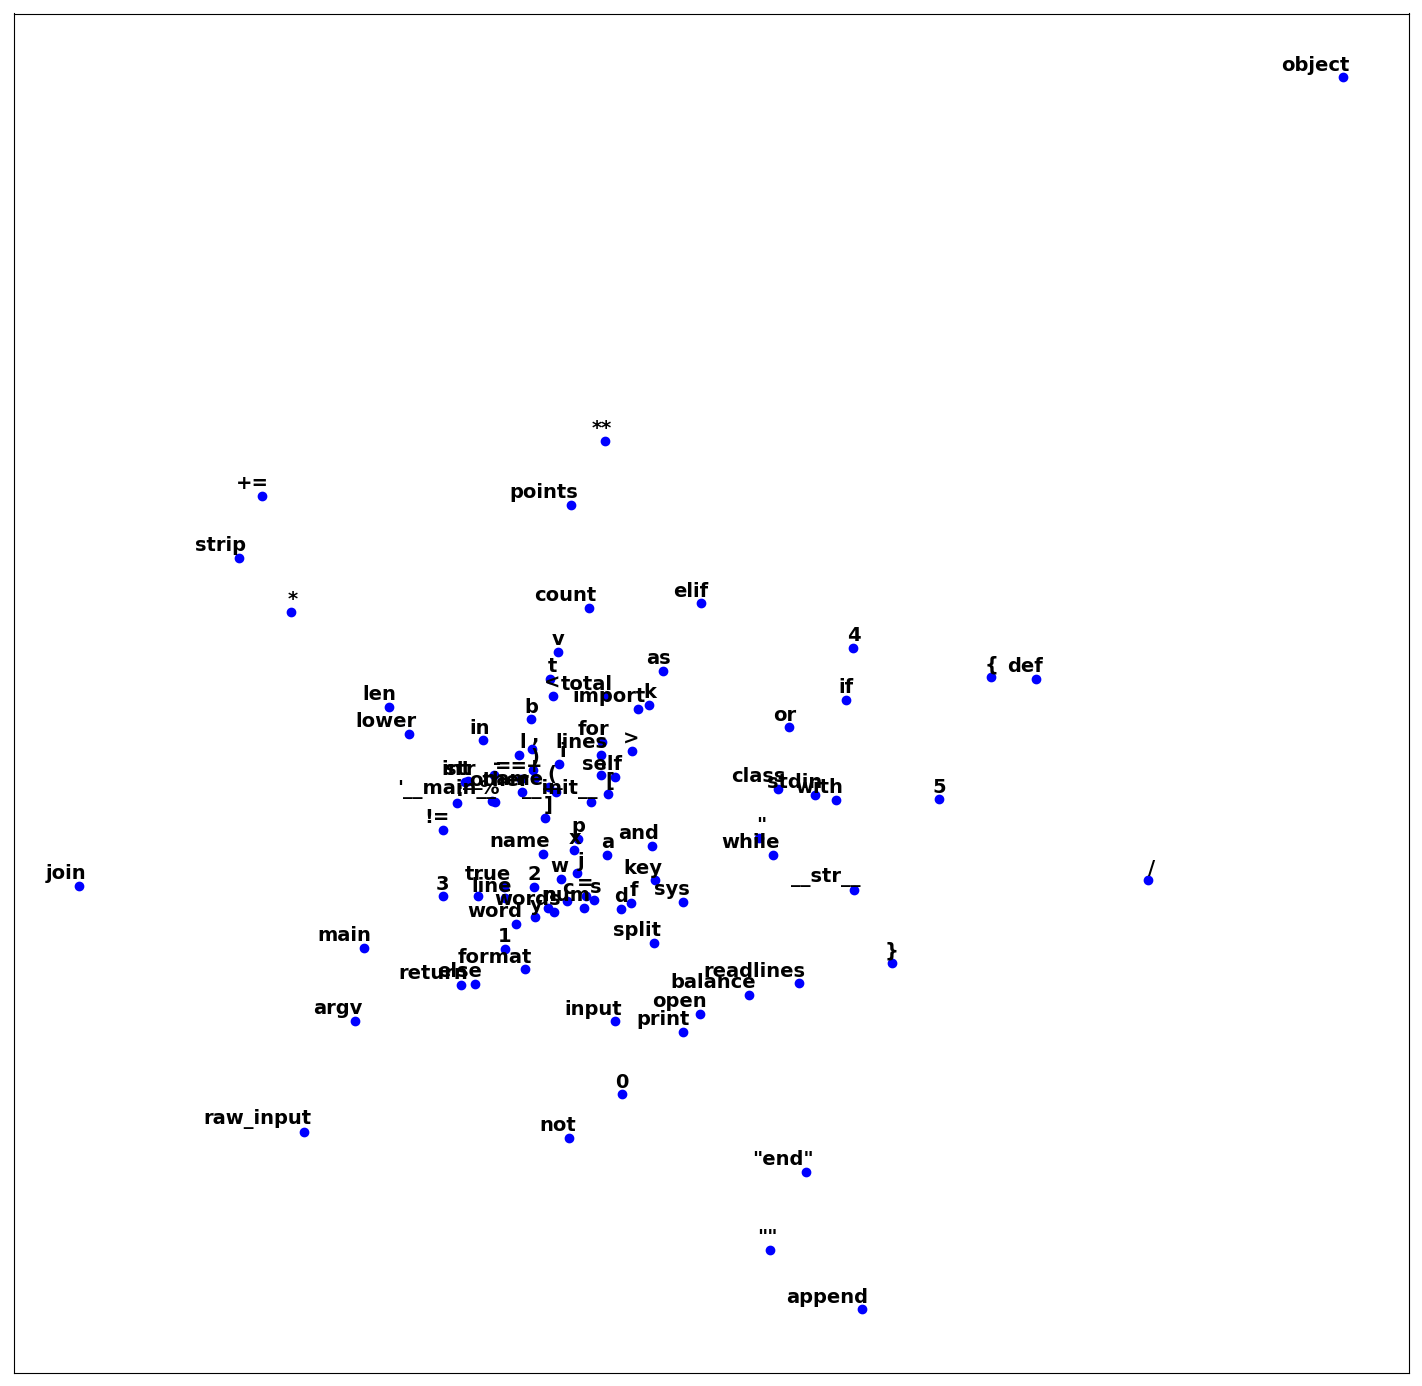

In [66]:
plot_embeddings(token_pca, id_to_token, token_top_words, figsize=(18, 18))

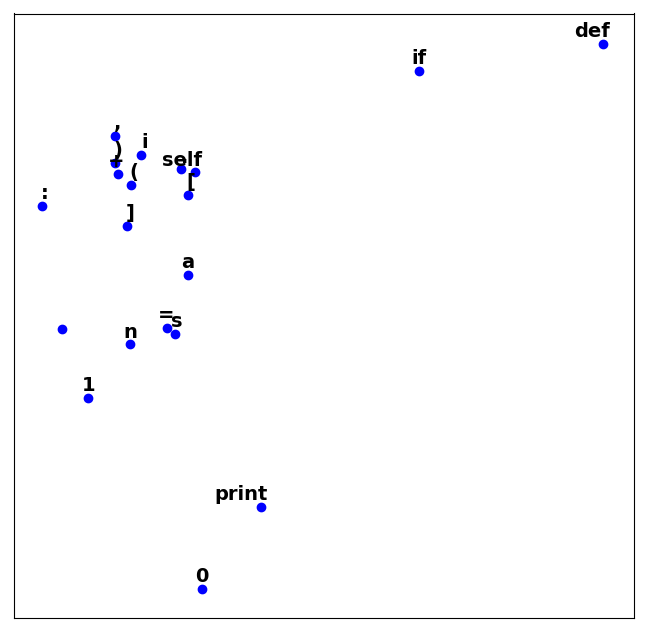

In [69]:
plot_embeddings(token_pca, id_to_token, get_top_words(token_t, 20))

Distances:

In [137]:
get_vector_cosine_distance(token_embeddings, token_t, '<', '>')

1.0424501410581446

In [139]:
get_vector_cosine_distance(token_embeddings, token_t, '+', '-')

0.98495930985536451

In [142]:
get_vector_cosine_distance(token_embeddings, token_t, 'if', 'elif')

0.84933024940274349

In [144]:
get_vector_cosine_distance(token_embeddings, token_t, 'elif', 'else')

0.97656496205184951

In [151]:
get_vector_cosine_distance(token_embeddings, token_t, '}', ']')

0.97557113871216028

In [209]:
# vector('Paris') - vector('France') + vector('Italy') results in a vector that is very close to vector('Rome')
vector = np.add( 
    np.subtract(token_embeddings[token_t.word_index['elif']], token_embeddings[token_t.word_index['else']]),
    token_embeddings[token_t.word_index['}']]
)

print euclidean(token_embeddings[token_t.word_index[']']], 
                vector)        

1.82041311264


In [147]:
get_vector_cosine_distance(token_embeddings, token_t, 'for', 'while')

0.7733401993401321

In [154]:
get_vector_cosine_distance(token_embeddings, token_t, '{', '}')

0.60193128879146662

In [155]:
get_vector_cosine_distance(token_embeddings, token_t, '(', ')')

1.0339526162255153

In [153]:
get_vector_cosine_distance(token_embeddings, token_t, '[', ']')

1.0140864425977205

Euclidean:

In [134]:
get_vector_distance(token_embeddings, token_t, '<', '>')

1.1479910612106323

In [138]:
get_vector_distance(token_embeddings, token_t, '+', '-')

1.030193567276001

In [140]:
get_vector_distance(token_embeddings, token_t, '==', '!=')

0.9673871397972107

In [141]:
get_vector_distance(token_embeddings, token_t, 'if', 'elif')

1.1479161977767944

In [143]:
get_vector_distance(token_embeddings, token_t, 'elif', 'else')

1.1544023752212524

In [145]:
get_vector_distance(token_embeddings, token_t, '*', '/')

2.578821897506714

In [146]:
get_vector_distance(token_embeddings, token_t, 'for', 'while')

1.0309348106384277

In [148]:
get_vector_distance(token_embeddings, token_t, '{', '[')

1.4444011449813843

In [149]:
get_vector_cosine_distance(token_embeddings, token_t, '{', '[')

0.77049372779290204

In [150]:
get_vector_distance(token_embeddings, token_t, '}', ']')

1.219957947731018

In [152]:
get_vector_distance(token_embeddings, token_t, '[', ']')

0.6866814494132996

In [121]:
get_vector_distance(token_embeddings, '(', ')')

2.234192132949829

Neighbors:

In [176]:
get_neighbors('if', token_embeddings, token_t, id_to_token, top_n=10)

living.": 1.64821843104
{:>15.2f}: 1.62586280748
e1: 1.59947053673
divide: 1.59054212159
perimeter: 1.58742218468
'{:.1f}': 1.57183911427
{:.2f}': 1.57122033937
',: 1.56500318722
way.": 1.55700839698
equal_to: 1.54083749407


In [162]:
get_neighbors('for', token_embeddings, token_t, id_to_token)

addr1: 1.45194526089
wise: 1.42280435606
character: 1.40919558812
diag: 1.40894389971
var: 1.3972191717


In [175]:
get_neighbors('i', token_embeddings, token_t, id_to_token, top_n=10)

'.': 1.53445816514
s1: 1.51405457413
format: 1.51078241159
phone: 1.41545004446
40000: 1.41384009972
lamp2: 1.41279061093
files: 1.39518511564
surname: 1.38525332157
aline: 1.38346564279
f_b: 1.36932189469


In [168]:
get_neighbors('print', token_embeddings, token_t, id_to_token, top_n=10)

bytes': 1.55978559258
dot: 1.55434937375
are.": 1.55240552452
break: 1.53127476363
add_contact: 1.52440845162
event: 1.51600289172
{:.2f}\nwages:: 1.51345256246
ds: 1.51274983043
digit: 1.48581057655
4:": 1.47579367811


In [210]:
get_neighbors('1', token_embeddings, token_t, id_to_token, top_n=20)

runner: 1.51560352695
"february": 1.51534985226
ip: 1.49672359
permis: 1.47753459586
"four": 1.47190829353
src: 1.45784648128
hundred": 1.45089330445
{:<3}: 1.45012711915
car: 1.4499237956
house": 1.44743486865
'words: 1.43987973926
isdigit: 1.43651588225
union: 1.43258015758
points: 1.4198956127
three: 1.41239701603
import: 1.41179546225
content: 1.41133345487
translate: 1.40840852646
wordcount: 1.40104853541
"translation.txt": 1.40050660175


### 2.2) Token categories

In [187]:
'Number encoded docs: {:,}'.format(len(token_ids))

'Number encoded docs: 472,087'

In [188]:
token_ids = [
    ' '.join([str(a) for a in array]) for array in token_ids
]

In [189]:
category_t = get_tokenizer()

category_t.fit_on_texts(token_ids)

In [190]:
# saving
with open('category_tokenizer.pickle', 'wb') as handle:
    pickle.dump(category_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [191]:
category_sequences = category_t.texts_to_sequences(token_ids)

id_to_category = { v: k for k, v in category_t.word_index.items() } # GET THE NAMES here for each category number?

category_padded_docs = pad_sequences(category_sequences, maxlen=MAX_LENGTH, padding='post')

In [192]:
category_model = get_model()

category_model.fit(category_padded_docs, 
                   token_labels,
                   batch_size=128,
                   epochs=2,
                   validation_split=0.2)

cat_loss, cat_accuracy = token_model.evaluate(category_padded_docs, token_labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (token_accuracy * 100, token_loss * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 377669 samples, validate on 94418 samples
Epoch 1/10
377669/377669 [==============================] - 24s 62us/step - loss: 0.6666 - acc: 0.5984 - val_loss: 0.6557 - val_acc: 0.6176
Epoch 2/10
377669/377669 [==============================] - 24s 63us/step - loss: 0.6635 - acc: 0.6010 - val_loss: 0.6488 - val_acc: 0.6301
Epoch 3/10
377669/377669 [==============================] - 23s 

In [195]:
category_embeddings = get_embeddings(category_model)

category_embeddings[0]

Embedding Layer shape: (2000, 100)


array([ -5.16307680e-03,   6.52739429e-04,   2.30813259e-03,
         1.03728771e-02,   6.64823921e-03,  -8.68725998e-04,
        -2.55746692e-02,   4.23573365e-04,   4.71815234e-03,
         2.02512695e-03,  -9.01811640e-04,  -2.92064360e-04,
         4.62578749e-03,  -4.50569729e-04,   5.85555611e-03,
        -8.84110946e-03,   7.46806851e-03,  -9.40822531e-04,
        -8.64801742e-03,   3.09951673e-03,  -3.27858655e-03,
         9.84578393e-03,   7.05924176e-05,  -2.85697961e-03,
         3.48953623e-03,   3.06673697e-04,   5.02196979e-03,
         7.47154525e-04,   3.09429038e-02,  -4.71507432e-03,
        -4.69689397e-03,   2.88977264e-03,   4.09395341e-03,
        -1.84008584e-03,  -8.68196716e-04,   3.42167076e-03,
        -3.25178029e-03,   4.04217094e-03,   2.66275997e-03,
        -6.40436914e-03,  -2.97195802e-05,   1.19678094e-03,
         2.17874460e-02,  -4.53241030e-03,   7.83637445e-03,
         1.06390174e-02,   5.57673676e-03,  -8.43823422e-03,
         3.54523025e-03,

In [196]:
np.save('data/processed/token_category_embeddings', category_embeddings)

In [197]:
category_pca = get_pca(category_embeddings)

PCA explained variance ratio: [ 0.29989067  0.0327782 ] Total: 0.332668863237


In [198]:
category_top_words = get_top_words(category_t, N=100)

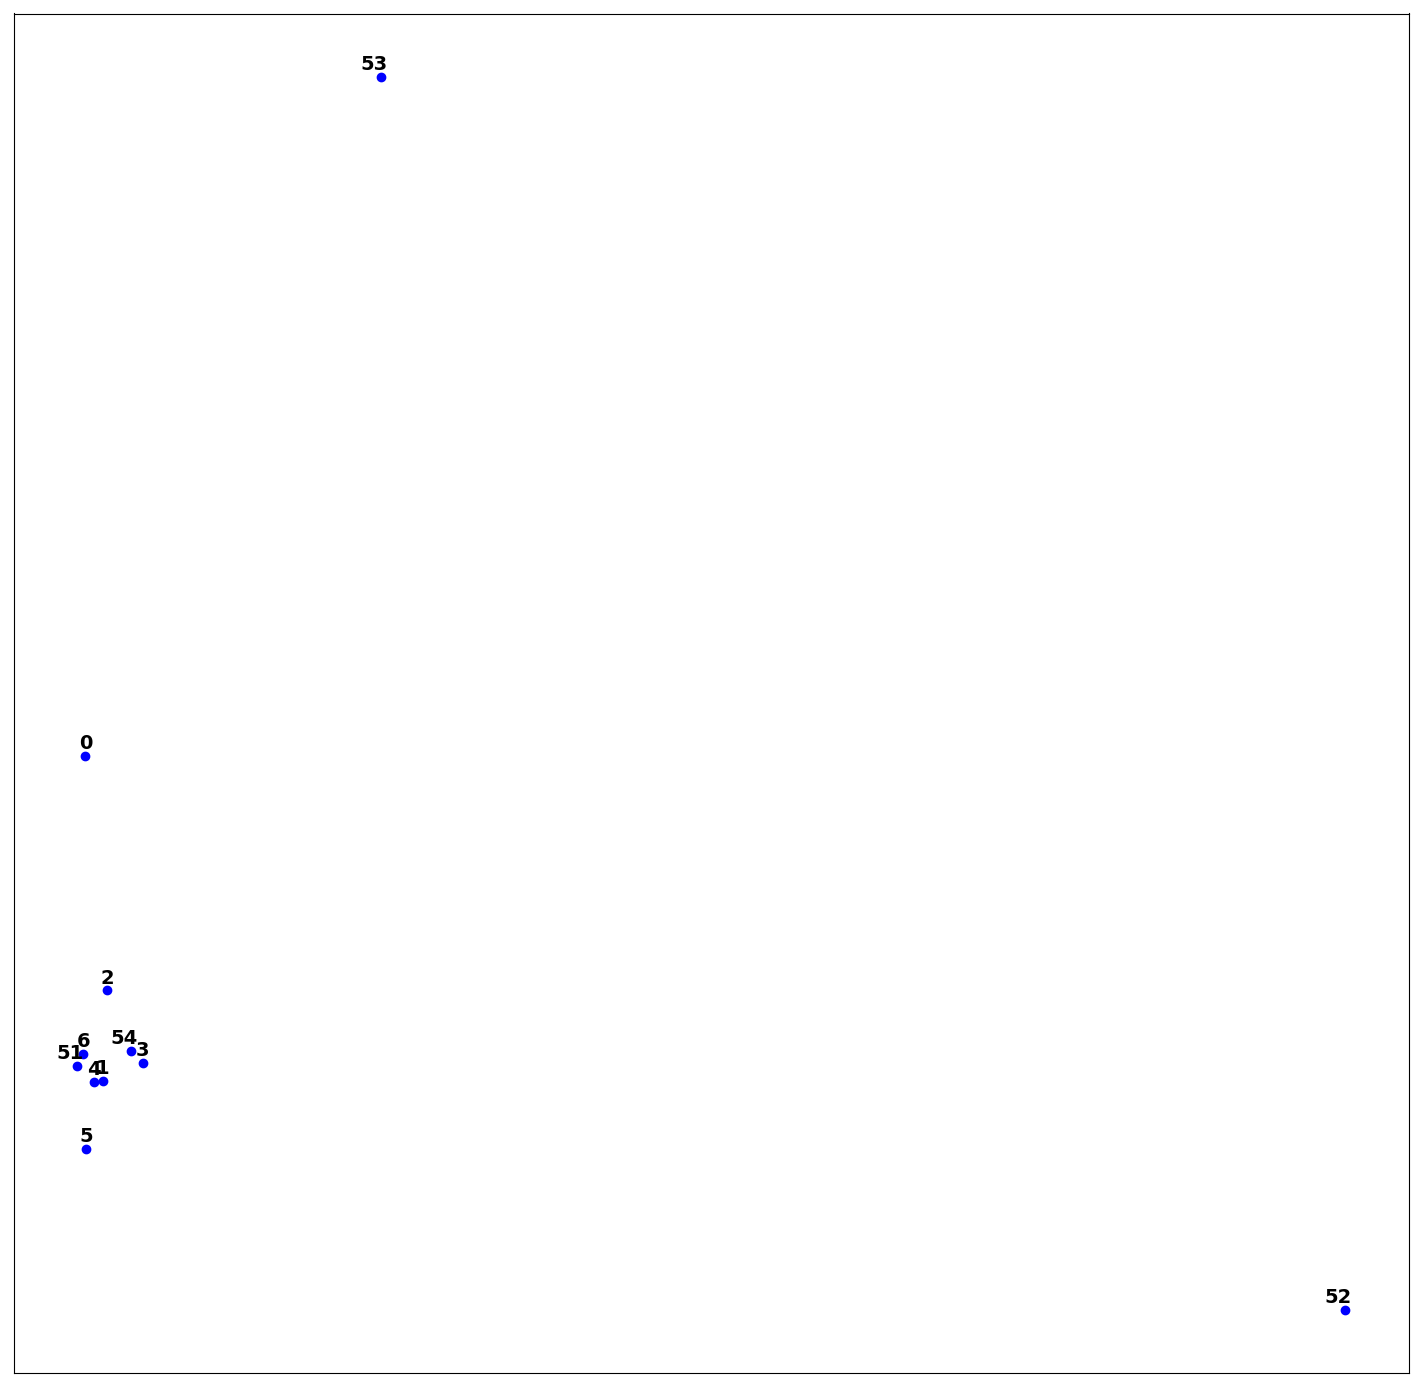

In [199]:
plot_embeddings(category_pca, id_to_category, category_top_words, figsize=(18, 18))

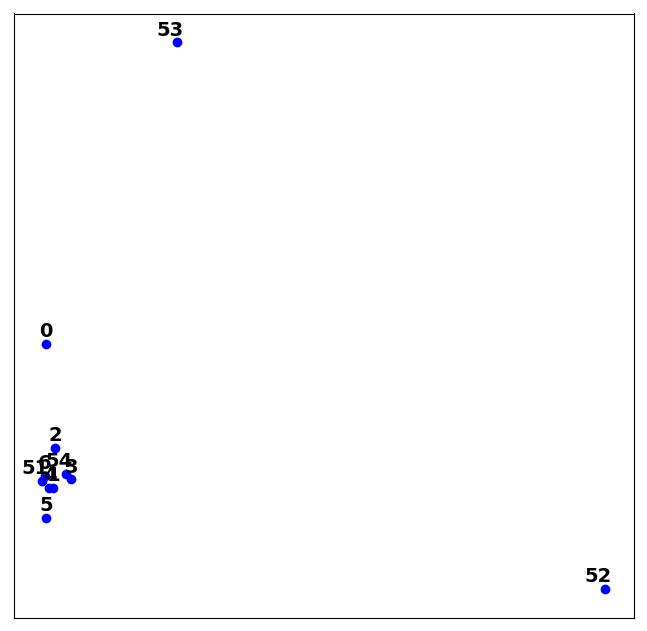

In [203]:
plot_embeddings(category_pca, id_to_category, get_top_words(category_t, 20))

## 3) Programs as Abstract Syntax Trees

In [62]:
# TODO

## SCORE

In [204]:
scores = {
    'Word NN': (word_loss, word_accuracy),
    'Word Token NN': (token_loss, token_accuracy),
    #'Category Token NN': (token_loss, token_accuracy),
    #'AST NN': (ast_loss, ast_accuracy),
}

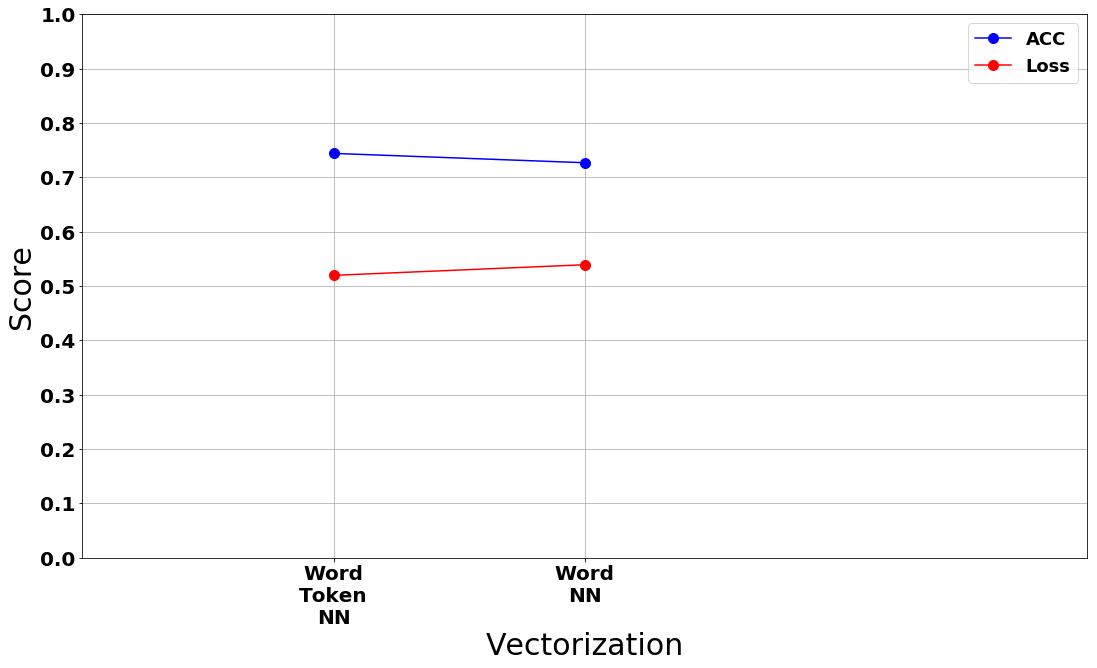

In [205]:
x = range(len(scores))
acc = [v[1] for k, v in scores.items()]
loss = [v[0] for k, v in scores.items()]
keys = [k.replace(' ', '\n') for k, v in scores.items()]

plt.subplots(figsize=(18, 10))
plt.grid()
plt.plot(x, acc, 'o-', color='b', label='ACC', markersize=10)
plt.plot(x, loss, 'o-', color='red', label='Loss', markersize=10)
plt.ylabel('Score', fontsize=30)
plt.xlabel('Vectorization', fontsize=30)
plt.xlim([-1, len(scores) + 1])
plt.xticks(x, keys)
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="upper right", fontsize=18)